<a href="https://colab.research.google.com/github/sg2083/GIS_repo/blob/main/ps1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Growth of Electric Vehicles**
This project studies the growth of electric vehicle (EV) charging stations and electric vehicles in
California counties. <br> We are analyzing how this growth relates to the increasing population and total
number of vehicles in each county. Our goal is to understand the relationship between electric vehicle adoption,
 population, vehicle population, and the availability of charging infrastructure across different areas in the state.
By exploring these factors, we can potentially predict and anticipate electric vehicle growth in the future.

In [7]:
%%capture
!pip install geopandas==1.0.1
!pip install mapclassify
!pip install reverse_geocoder

In [8]:
# All Imports
import os, zipfile #basics
import pandas as pd #data management
import matplotlib.pyplot as plt #vis
import csv #to read csv files
from shapely.geometry import Point
import reverse_geocoder as rg

import geopandas as gpd #gis/maps: a sister of pandas; does the job;

import mapclassify #need for thematic map classification

#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import files #to download from colab onto hd

from google.colab import data_table
data_table.enable_dataframe_formatter()

In [9]:
gpd.__version__

'1.0.1'

<Axes: >

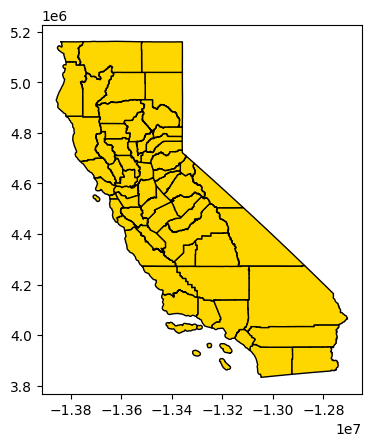

In [10]:
zip_ref = zipfile.ZipFile('ca_counties.zip', 'r')
zip_ref.extractall('California_Shape_Files') # Extract all files to a specific directory

CAl0=gpd.read_file('California_Shape_Files/CA_Counties.shp') #load the shapefile with gpd as tlC
zip_ref.close() # Close the zip file after reading the shapefile
CAl0.plot(color='gold', edgecolor='black') # Change color to lightgreen, edgecolor to black
plt.show()


In [11]:
# Checking for the data types and checking the values of the data
CAl0.dtypes
CAl0[CAl0.columns.difference(['geometry'])].head(2)

# Selecting only Few Variables for the Table
CAl=CAl0[['NAME','NAMELSAD','Shape_Area','geometry']]

,0
STATEFP,object
COUNTYFP,object
COUNTYNS,object
GEOID,object
NAME,object
NAMELSAD,object
LSAD,object
CLASSFP,object
MTFCC,object
CSAFP,object


,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,METDIVFP,MTFCC,NAME,NAMELSAD,STATEFP,Shape_Area,Shape_Leng
0,2.468695e+09,23299110.0,None,H1,091,00277310,None,A,06091,+39.5769252,-120.5219926,06,None,G4020,Sierra,Sierra County,06,4.200450e+09,375602.758281
1,2.499984e+09,75425434.0,40900,H1,067,00277298,472,A,06067,+38.4500161,-121.3404408,06,None,G4020,Sacramento,Sacramento County,06,4.205516e+09,406584.174167


### **Exploring and Manipulating Population Data Of California**
taking a text file of California's population data and manipulating it to fit the structure of a pre-selected table. The goal is to ***clean, format, and align the data*** for further analysis.
Then we'll plot the latest data on the Shape File of California.

In [12]:
#Data cleaning and merging for plotting
# Define the input file path to get the population value
input_file = 'population_data.txt'

# Read the CSV data from the text file
data = []
with open(input_file, 'r') as txt_file:
    csv_reader = csv.reader(txt_file)
    headers = next(csv_reader)  # Skip the header
    for row in csv_reader:
        data.append(row)

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['Year', 'Period', 'Area', 'Population Source', 'Population'])

# Convert Population to numeric
df['Population'] = pd.to_numeric(df['Population'].str.replace(",", ""))

# Population_of_california  the DataFrame to restructure it
POP_CAL_pivot_df = df.pivot_table(index='Area', columns='Year', values='Population')

# Rename columns for clarity (optional)
POP_CAL_pivot_df.columns = [f'Year-{col}' for col in POP_CAL_pivot_df.columns]

# Reset index to make 'Area' a column again
POP_CAL_pivot_df = POP_CAL_pivot_df.reset_index()

# Print the result
print(POP_CAL_pivot_df)

# Optionally, save the result to a CSV file
POP_CAL_pivot_df.to_csv('year-wise.csv', index=False)


                      Area  Year-1995   Year-2007   Year-2018  Year-2022
0           Alameda County  1332936.0   1527809.0   1669659.0  1649975.0
1            Alpine County     1145.0      1252.0      1208.0     1175.0
2            Amador County    33293.0     38161.0     40038.0    40105.0
3             Butte County   196394.0    218836.0    234627.0   206498.0
4         Calaveras County    37979.0     45966.0     45365.0    44769.0
5            Colusa County    17694.0     21761.0     21690.0    21814.0
6      Contra Costa County   869176.0   1041428.0   1158017.0  1150114.0
7         Del Norte County    27843.0     29260.0     27572.0    26738.0
8         El Dorado County   143862.0    178672.0    187122.0   189386.0
9            Fresno County   748424.0    919864.0    993965.0  1011462.0
10            Glenn County    26161.0     28986.0     28134.0    28449.0
11         Humboldt County   124721.0    132172.0    137493.0   134657.0
12         Imperial County   134848.0    173615.0  

After refining the dataset, we integrate it with shapefile data to create an engaging thematic map, showcasing the population distribution for 2022.

<Axes: >

[]

[]

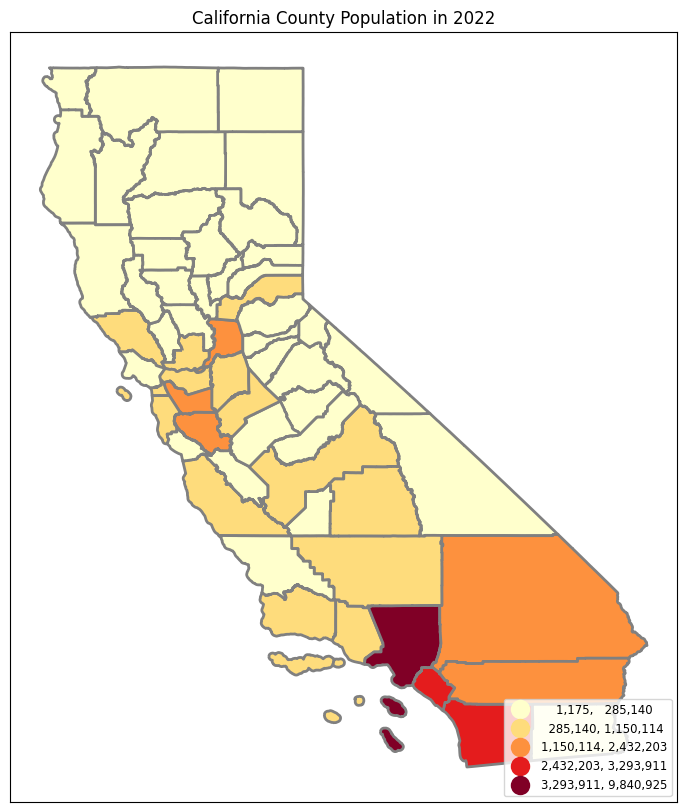

In [13]:
# Plotting Population Data on California Map By Merging it on Basis of County
after_merge=CAl.merge(POP_CAL_pivot_df, left_on='NAMELSAD', right_on='Area',how='left')
fig, ax = plt.subplots(1, figsize=(20, 10))

after_merge.plot(ax=ax,
         column='Year-2022',         # Change this to any other year if needed (e.g., 'Year-2007','Year-2018','Year-2022' ,'Year-1995')
         legend=True,
         cmap='YlOrRd',                # Yellow to Red color gradient
         scheme='natural_breaks',    # Classify data into natural breaks (Jenks)
         k=5,                        # Number of classes
         vmin=0.1 ,
         edgecolor='grey',           # Border color for counties
         linewidth=2,                # Line width for borders
         legend_kwds={               # Customize the legend
             "fmt": "{:,.0f}",       # Format numbers with commas and no decimal points
             'loc': 'lower right',   # Legend location
             'title_fontsize': 'medium',  # Title font size for the legend
             'fontsize': 'small',         # Font size for the legend
             'markerscale': 1.4           # Scale of the markers in the legend
         })

ax.title.set_text("California County Population in 2022")

ax.set_xticks([])
ax.set_yticks([])

## **Exploring Industries Data**
We explored data from different industries to see how population and industries are connected. To do this, we made a plot showing the availability of tech and education services in each county across California

       NAME_x           NAMELSAD    Shape_Area  \
0      Sierra      Sierra County  4.200450e+09   
1  Sacramento  Sacramento County  4.205516e+09   

                                            geometry  Year-1995  Year-2007  \
0  POLYGON ((-120.6556 39.69357, -120.65554 39.69...     3527.0     3395.0   
1  POLYGON ((-121.18858 38.71431, -121.18732 38.7...  1118579.0  1411089.0   

   Year-2018  Year-2022    ID  INDTECH_CY  INDEDUC_CY  
0     3232.0     3186.0  6091          64          91  
1  1554668.0  1578644.0  6067       49679       53512  


<Axes: >

[]

[]

<Axes: >

[]

[]

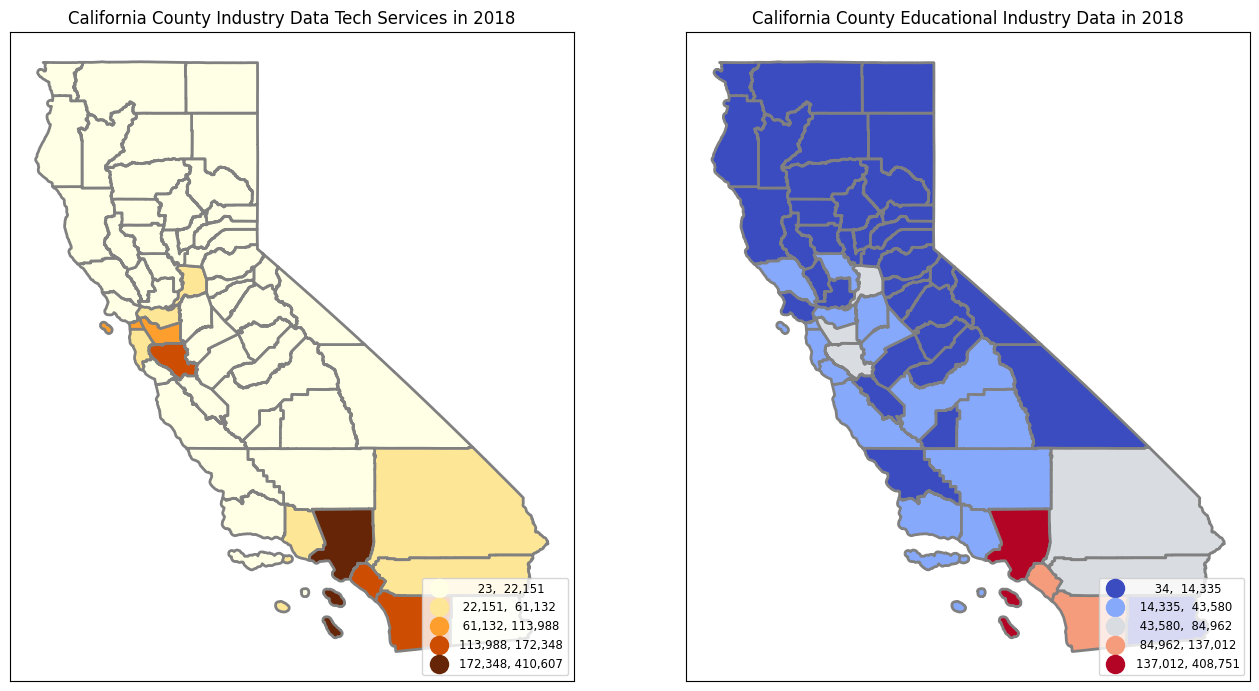

In [22]:
df_industry = pd.read_csv('County_Industry_Data.csv')
df_industry_filter = df_industry[df_industry['ST_ABBREV'] == 'CA']
get_df_industry = df_industry_filter[['ID','NAME','INDTECH_CY','INDEDUC_CY']]

after_merge_industry=after_merge.merge(get_df_industry, left_on='NAMELSAD', right_on='NAME',how='left')
after_merge_industry = after_merge_industry.drop(columns=['Area', 'NAME_y'])
print(after_merge_industry.head(2))

fig, ax = plt.subplots(1,2, figsize=(16, 10))

after_merge_industry.plot(ax=ax[0],
         column='INDTECH_CY',        # Change this to any other year if needed (e.g., 'Year-2007', 'Year-1995')
         legend=True,
         cmap='YlOrBr',             # Yellow to Red color gradient
         scheme='natural_breaks',    # Classify data into natural breaks (Jenks)
         k=5,                      # Number of classes
         vmin=0.1 ,
         edgecolor='grey',           # Border color for counties
         linewidth=2,                # Line width for borders
         legend_kwds={               # Customize the legend
             "fmt": "{:,.0f}",       # Format numbers with commas and no decimal points
             'loc': 'lower right',   # Legend location
             'title_fontsize': 'medium',  # Title font size for the legend
             'fontsize': 'small',         # Font size for the legend
             'markerscale': 1.4           # Scale of the markers in the legend
         })

ax[0].title.set_text("California County Industry Data Tech Services in 2018")

ax[0].set_xticks([])
ax[0].set_yticks([])

after_merge_industry.plot(ax=ax[1],
         column='INDEDUC_CY',        # Change this to any other year if needed (e.g., 'Year-2007', 'Year-1995')
         legend=True,
         cmap='coolwarm',             # Yellow to Red color gradient
         scheme='natural_breaks',    # Classify data into natural breaks (Jenks)
         k=5,                      # Number of classes
         vmin=0.1 ,
         edgecolor='grey',           # Border color for counties
         linewidth=2,                # Line width for borders
         legend_kwds={               # Customize the legend
             "fmt": "{:,.0f}",       # Format numbers with commas and no decimal points
             'loc': 'lower right',   # Legend location
             'title_fontsize': 'medium',  # Title font size for the legend
             'fontsize': 'small',         # Font size for the legend
             'markerscale': 1.4           # Scale of the markers in the legend
         })

ax[1].title.set_text("California County Educational Industry Data in 2018")

ax[1].set_xticks([])
ax[1].set_yticks([])



## **Mapping Electric Vehicle Charging Stations**
We obtained electric vehicle data that needed cleaning. Although the exact location of the charging stations wasn’t provided, we had longitude and latitude coordinates. Using this, we identified the county for each station and added that information to the data. After merging the longitude and latitude values to create the geometric points, we successfully plotted the EV stations on the map.

In [26]:
# Reading EV Charging Station Data
ev_data = pd.read_csv('ev_data.csv')
ev_data.head(10)

,X,Y,OBJECTID_1,StationDesignation,FuelTypeCode,StationName,StreetAddress,IntersectionDirections,City_1,State,...,EVWorkplaceCharging,EVTotalPortCountBeta,EVCHAdeMOPortCountBeta,EVJ1772PortCountBeta,EVCCSPortCountBeta,EVNEMA1450PortCountBeta,EVNEMA515PortCountBeta,EVNEMA520PortCountBeta,EVTeslaPortCountBeta,EVCCS150pluskWPortCountBeta
0,-170926.820341,98037.146589,1,NEVI Compliant,ELEC,America's Best Value Inn,3930 County Road 89,NaN,Dunnigan,CA,...,False,4,1,0,4,0,0,0,0,4
1,-162082.004149,-33590.692802,2,NEVI Compliant,ELEC,San Francisco Premium Outlets,2774 Livermore Outlets Dr.,NaN,Livermore,CA,...,False,10,1,0,10,0,0,0,0,10
2,154228.858624,-423885.300851,3,NEVI Compliant,ELEC,"Walmart 5686 - Burbank, CA",1301 N. Victory Place,NaN,Burbank,CA,...,False,10,1,0,10,0,0,0,0,10
3,-348792.844526,425087.789360,4,NEVI Compliant,ELEC,"Walmart 1910 - Crescent City, CA",900 East Washington Blvd,NaN,Crescent City,CA,...,False,4,1,0,4,0,0,0,0,4
4,226333.774936,-435004.773986,5,NEVI Compliant,ELEC,Ontario Mills,950 Ontario Mills Dr,NaN,Ontario,CA,...,False,8,1,0,8,0,0,0,0,7
5,-77038.448799,-56121.321146,6,NEVI Compliant,ELEC,"Walmart 1963 - Turlock, CA",2111 Fulkerth Road,NaN,Turlock,CA,...,False,4,1,0,4,0,0,0,0,4
6,-220477.605888,412171.502967,7,NEVI Compliant,ELEC,"Walmart 1630 - Yreka, CA",1906 Fort Jones Road,NaN,Yreka,CA,...,False,4,1,0,4,0,0,0,0,4
7,349443.729361,-467893.828273,8,NEVI Compliant,ELEC,"Walmart 2181 - Indio, CA",82-491 Avenue 42,NaN,Indio,CA,...,False,4,1,0,4,0,0,0,0,4
8,-167743.992174,-65355.142328,9,NEVI Compliant,ELEC,Great Mall,447 Great Mall Drive,NaN,Milpitas,CA,...,False,4,1,0,4,0,0,0,0,4
9,184130.798654,-472493.733138,10,NEVI Compliant,ELEC,Westminster Mall,75 Westminster Mall,NaN,Westminster,CA,...,False,4,1,0,4,0,0,0,0,4


In [16]:
# Function to get county name
def get_county_from_lat_lon(lat, lon):
    coordinates = (lat, lon)
    result = rg.search(coordinates)  # Returns a list of dictionaries
    return result[0]['admin2']

# Apply the function to each row
for index, row in ev_data.iterrows():
    ev_data.loc[index, 'County'] = get_county_from_lat_lon(row['Latitude'], row['Longitude'])

#  Updated ev_data with county information
ev_data.to_csv('ev_data_with_county.csv', index=False)


Loading formatted geocoded file...


In [17]:
ev_data_with_county = pd.read_csv('ev_data_with_county.csv')
ev_data_with_county.head(3)

,X,Y,OBJECTID_1,StationDesignation,FuelTypeCode,StationName,StreetAddress,IntersectionDirections,City_1,State,...,EVTotalPortCountBeta,EVCHAdeMOPortCountBeta,EVJ1772PortCountBeta,EVCCSPortCountBeta,EVNEMA1450PortCountBeta,EVNEMA515PortCountBeta,EVNEMA520PortCountBeta,EVTeslaPortCountBeta,EVCCS150pluskWPortCountBeta,County
0,-170926.820341,98037.146589,1,NEVI Compliant,ELEC,America's Best Value Inn,3930 County Road 89,NaN,Dunnigan,CA,...,4,1,0,4,0,0,0,0,4,Yolo County
1,-162082.004149,-33590.692802,2,NEVI Compliant,ELEC,San Francisco Premium Outlets,2774 Livermore Outlets Dr.,NaN,Livermore,CA,...,10,1,0,10,0,0,0,0,10,Alameda County
2,154228.858624,-423885.300851,3,NEVI Compliant,ELEC,"Walmart 5686 - Burbank, CA",1301 N. Victory Place,NaN,Burbank,CA,...,10,1,0,10,0,0,0,0,10,Los Angeles County


<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'EV Charging Stations by County')

Text(0.5, 80.7222222222222, 'Longitude')

Text(144.61080201807664, 0.5, 'Latitude')

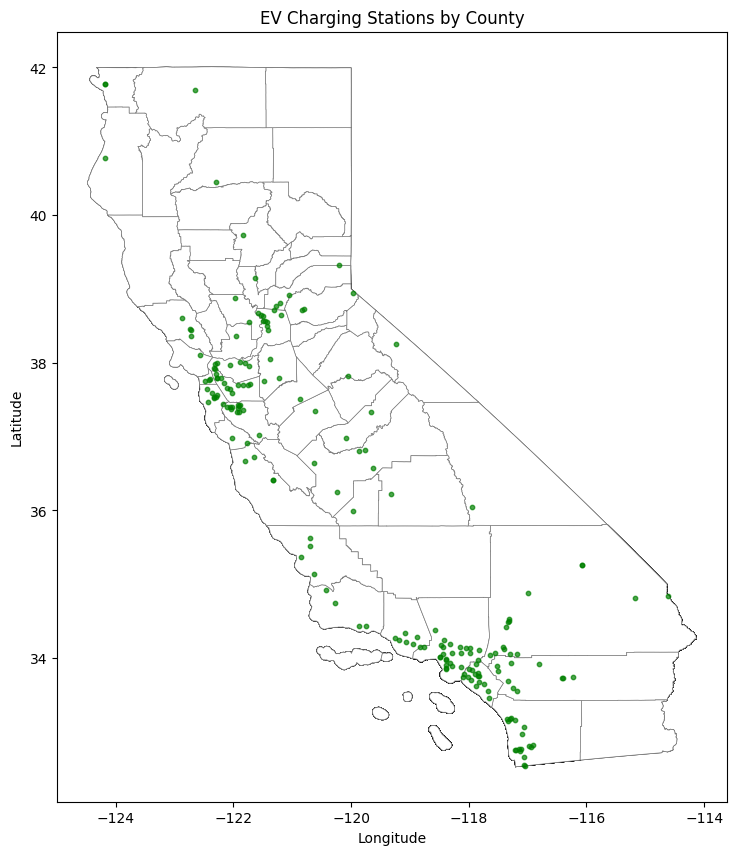

In [40]:
# Create a GeoDataFrame with geometry for EV stations
ev_gdf = gpd.GeoDataFrame(
    ev_data_with_county,
    geometry=gpd.points_from_xy(ev_data_with_county.Longitude, ev_data_with_county.Latitude)
)

# Explicitly set the CRS of ev_gdf to match tlC0 - replace 'epsg:xxxx' with the actual EPSG code
ev_gdf = ev_gdf.set_crs("epsg:4326")
after_merge = after_merge.to_crs("epsg:4326")


merged_data = after_merge.merge(ev_data_with_county, left_on='NAMELSAD', right_on='County', how='left')
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the county boundaries
merged_data = merged_data.set_geometry('geometry') # Set the active geometry column to county boundaries
merged_data.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

after_merge.plot(ax=ax, color='white', edgecolor='grey', linewidth=0.5)
# Plot the EV locations using the ev_gdf GeoDataFrame
ev_gdf.plot(ax=ax, marker='o', color='Green', markersize=10, alpha=0.7)

# Set plot title and labels
plt.title('EV Charging Stations by County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## **Analyzing Electric Vehicle Distribution and Charging Station Accessibility in California**
We analyzed EV data across California and visualized it. Next, we layered the locations of charging stations and EVs on the map to see if the stations are placed where they’re most needed.

In [19]:
vehicle_pop = pd.read_excel('vehicle_pop.xlsx', sheet_name='County')

# Filter the DataFrame Cleaning and adjusting data according to our Data Set
filtered_vehicle_pop = vehicle_pop[(vehicle_pop['Data Year'] == 2023) &
                                  (vehicle_pop['Fuel Type'].isin(['Battery Electric (BEV)','Plug-in Hybrid (PHEV)']))]

# Group by county and fuel type and get the count
county_fuel_count = filtered_vehicle_pop.groupby(['County', 'Fuel Type'])['Number of Vehicles'].sum().reset_index()

# Pivot the table for better readability
county_fuel_pivot = county_fuel_count.pivot(index='County', columns='Fuel Type', values='Number of Vehicles').reset_index()

# Add a new column 'Total' for the sum of BEV and PHEV
county_fuel_pivot['Total_EV_Vehicles'] = county_fuel_pivot['Battery Electric (BEV)'] + county_fuel_pivot['Plug-in Hybrid (PHEV)']

# Print the result
print(county_fuel_pivot.head(2))


Fuel Type   County  Battery Electric (BEV)  Plug-in Hybrid (PHEV)  \
0          Alameda                   75187                  21195   
1           Alpine                      19                     13   

Fuel Type  Total_EV_Vehicles  
0                      96382  
1                         32  


,Area,Battery Electric (BEV),County,NAME,NAMELSAD,Plug-in Hybrid (PHEV),Shape_Area,Total_EV_Vehicles,Year-1995,Year-2007,Year-2018,Year-2022
0,Sierra County,19,Sierra,Sierra,Sierra County,6,4.200450e+09,25,3527.0,3395.0,3232.0,3186.0
1,Sacramento County,31628,Sacramento,Sacramento,Sacramento County,13032,4.205516e+09,44660,1118579.0,1411089.0,1554668.0,1578644.0
2,Santa Barbara County,8578,Santa Barbara,Santa Barbara,Santa Barbara County,3254,1.449841e+10,11832,382373.0,424978.0,447666.0,443956.0
3,Calaveras County,420,Calaveras,Calaveras,Calaveras County,282,4.356213e+09,702,37979.0,45966.0,45365.0,44769.0
4,Ventura County,23553,Ventura,Ventura,Ventura County,8226,8.413293e+09,31779,702830.0,823538.0,849523.0,830434.0


<Axes: >

Text(0.5, 1.0, 'Total BEV and PHEV Vehicles by County')

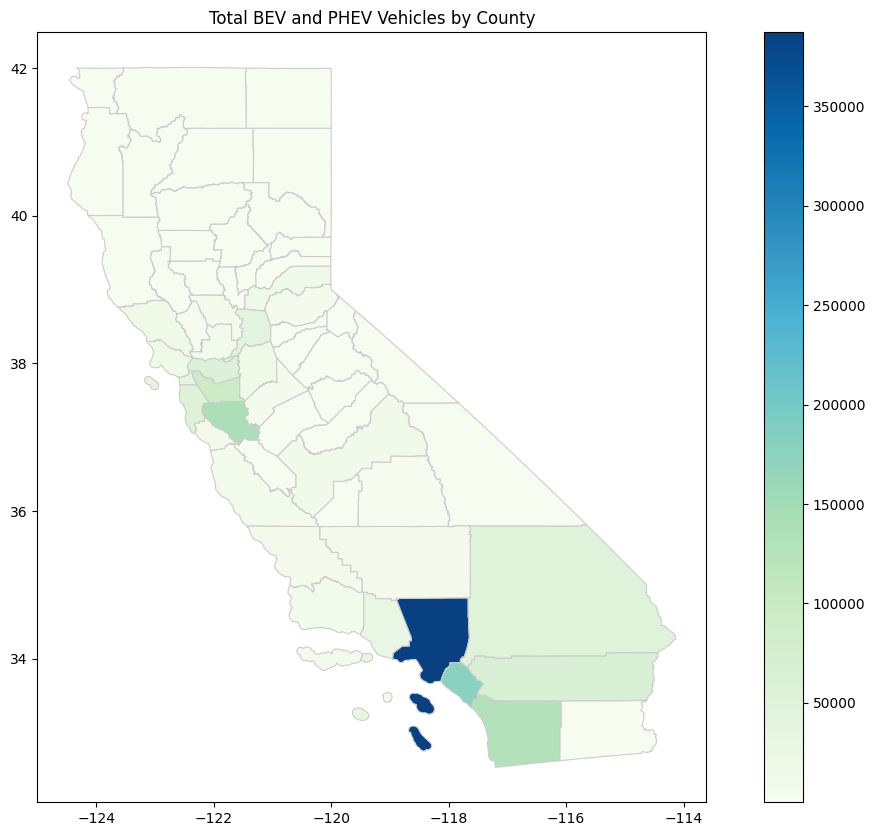

In [30]:
#merging
merged_data = after_merge.merge(county_fuel_pivot, left_on='NAME', right_on='County', how='left')
merged_data[merged_data.columns.difference(['geometry'])].head(5)

# Create a thematic map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.plot(column='Total_EV_Vehicles',
                cmap='GnBu',
                linewidth=0.8,
                edgecolor='0.8',
                legend=True,
                ax=ax,
                missing_kwds={'color': 'lightgrey'})


ax.set_title('Total BEV and PHEV Vehicles by County')
plt.show()

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Total BEV and PHEV Vehicles by County and EV Charging Stations Available')

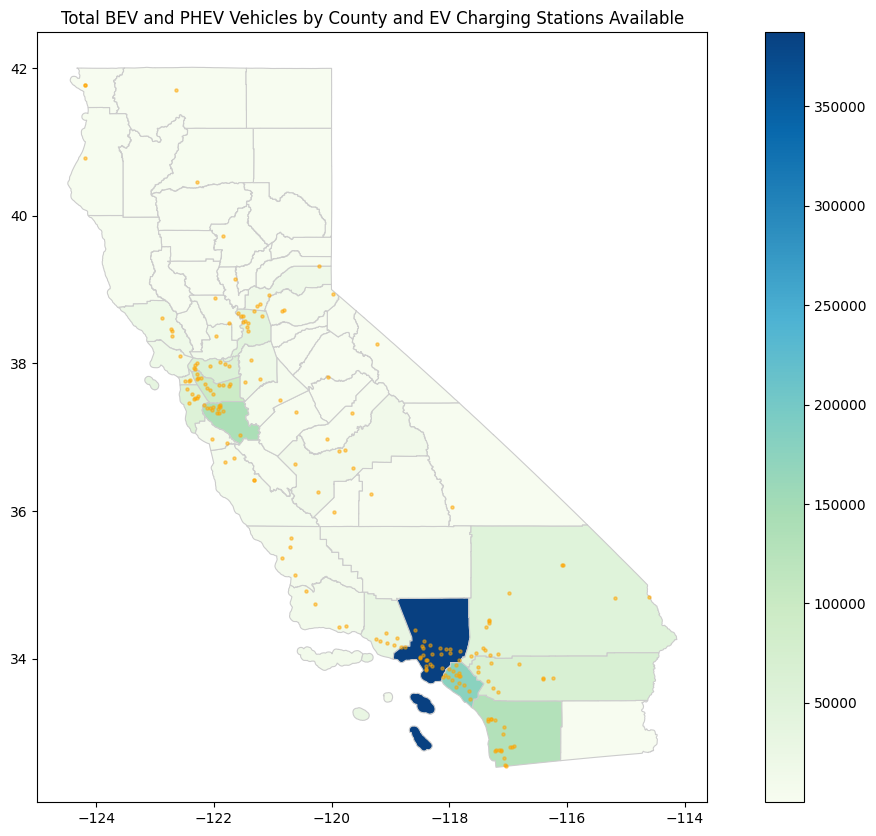

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.plot(column='Total_EV_Vehicles',
                cmap='GnBu',
                linewidth=0.8,
                edgecolor='0.8',
                legend=True,
                ax=ax,
                missing_kwds={'color': 'lightgrey'})

ev_gdf.plot(ax=ax, marker='o', color='Orange', markersize=5, alpha=0.5)

ax.set_title('Total BEV and PHEV Vehicles by County and EV Charging Stations Available')
plt.show()


<Axes: >

<Axes: >

Text(0.5, 1.0, 'Total BEV and PHEV Vehicles by County and Population Density of 2022')

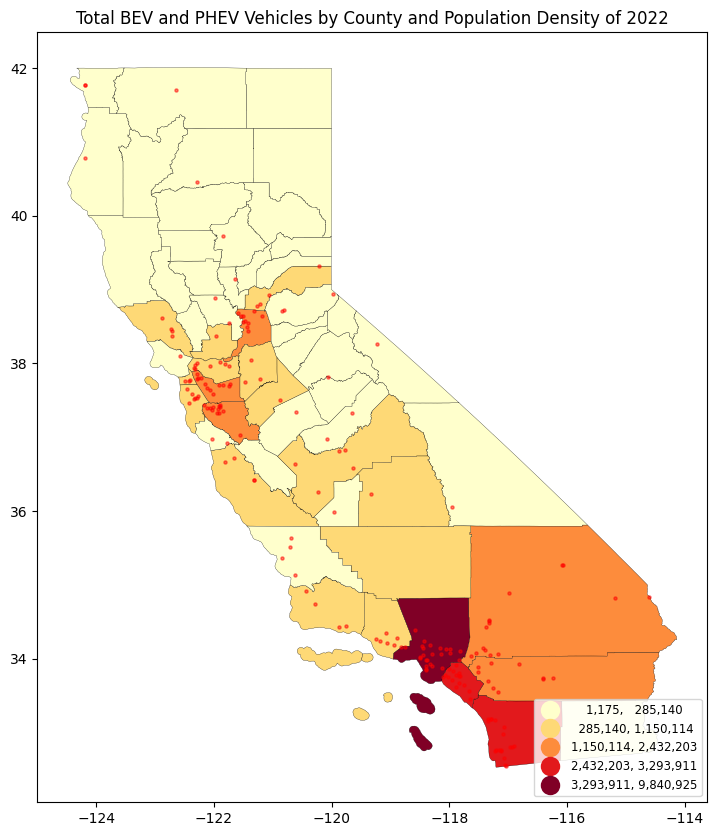

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.plot(
                column='Year-2022',
                cmap='YlOrRd',
                linewidth=0.2,
                edgecolor='black',
                scheme='natural_breaks',
                legend=True,
                ax=ax,
                k=5,
                missing_kwds={'color': 'lightgrey'},
                legend_kwds={                # Customize the legend
                "fmt": "{:,.0f}",               # Format numbers with commas and no decimal points
                'loc': 'lower right',           # Legend location
                'title_fontsize': 'medium',     # Title font size for the legend
                'fontsize': 'small',             # Font size for the legend
                'markerscale': 1.4     }
                 )
ev_gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.5)

ax.set_title('Total BEV and PHEV Vehicles by County and Population Density of 2022')
plt.show()